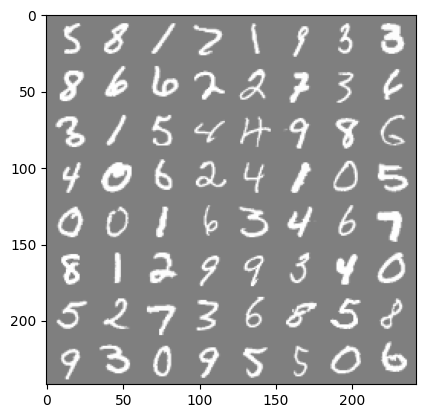

[1,   100] loss: 1.151
[1,   200] loss: 0.344
[1,   300] loss: 0.229
[1,   400] loss: 0.188
[1,   500] loss: 0.162
[1,   600] loss: 0.139
[1,   700] loss: 0.124
[1,   800] loss: 0.131
[1,   900] loss: 0.113
[2,   100] loss: 0.095
[2,   200] loss: 0.095
[2,   300] loss: 0.077
[2,   400] loss: 0.087
[2,   500] loss: 0.079
[2,   600] loss: 0.074
[2,   700] loss: 0.068
[2,   800] loss: 0.069
[2,   900] loss: 0.079
[3,   100] loss: 0.066
[3,   200] loss: 0.064
[3,   300] loss: 0.056
[3,   400] loss: 0.055
[3,   500] loss: 0.049
[3,   600] loss: 0.051
[3,   700] loss: 0.060
[3,   800] loss: 0.048
[3,   900] loss: 0.053
[4,   100] loss: 0.041
[4,   200] loss: 0.049
[4,   300] loss: 0.043
[4,   400] loss: 0.054
[4,   500] loss: 0.047
[4,   600] loss: 0.042
[4,   700] loss: 0.037
[4,   800] loss: 0.046
[4,   900] loss: 0.039
[5,   100] loss: 0.034
[5,   200] loss: 0.037
[5,   300] loss: 0.034
[5,   400] loss: 0.030
[5,   500] loss: 0.035
[5,   600] loss: 0.040
[5,   700] loss: 0.039
[5,   800] 

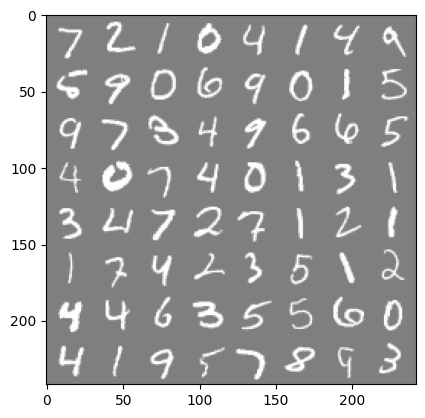

GroundTruth:  7     2     1     0    
Predicted:  7     2     1     0    
Accuracy of the network on the 10000 test images: 98 %


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import struct 
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Adjust input channels from 3 to 1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjust input size after pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Function to read IDX files
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Load the training images and labels
train_images = read_idx('/kaggle/input/mnist-dataset/train-images.idx3-ubyte')
train_labels = read_idx('/kaggle/input/mnist-dataset/train-labels.idx1-ubyte')

# Load the test images and labels
test_images = read_idx('/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte')
test_labels = read_idx('/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte')

# Convert NumPy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the classes for the MNIST dataset
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def imshow(img):
    img = img / 2 + 0.5
    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# Train the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use next() to get the first batch

# Print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


In [2]:
!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 15517, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 15517 (delta 74), reused 188 (delta 48), pack-reused 15275
Receiving objects: 100% (15517/15517), 6.39 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (11185/11185), done.


In [3]:
%cd detectron2

/kaggle/working/detectron2


In [4]:
!pip install -U .

Processing /kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 852.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.5 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=1254068 sha256=97eeb9ed8aece60514399fe97fde659f0c9c338c220e30fd5476163054d08d78
  Stored in directory: /tm

In [5]:
pip wheel .

Processing /kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
  Using cached yacs-0.1.8-py3-none-any.whl.metadata (639 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.1 MB/s eta 0:00:00
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Using cached iopath-0.1.9-py3-none-any.whl.metadata (370 bytes)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached black-24.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (75 kB)
  Using cached packaging-24.0-py3-none-any.whl.metadata (3.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
  Using cached portalocker-2.8.2-py3-none-any.whl.metadata (8.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import torch
import detectron2
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torchvision.datasets import MNIST
from torchvision import transforms
import cv2
from detectron2 import model_zoo
from sklearn.metrics import accuracy_score

!pip install --no-index ../input/detectron2-download-code-for-offline-install-ii/detectron2/detectron2-0.6-cp37-cp37m-linux_x86_64.whl --find-links=../input/detectron2-download-code-for-offline-install-ii/detectron2

# Helper function to convert MNIST dataset to Detectron2 format
def get_mnist_dicts(mode):
    dataset = MNIST(root='./data', train=(mode=='train'), download=True, transform=transforms.Compose([
        transforms.ToTensor(),
    ]))
    dataset_dicts = []
    for idx in range(len(dataset)):
        record = {}
        img, lbl = dataset[idx]
        img = np.array(img.permute(1, 2, 0) * 255, dtype=np.uint8)  # Convert to numpy array
        record["file_name"] = f"data/img_{idx}.png"  # Save image to file
        cv2.imwrite(record["file_name"], img)
        height, width = img.shape[:2]
        record["height"] = height
        record["width"] = width
        record["image_id"] = idx
        record["annotations"] = [{"bbox": [0, 0, width, height], "bbox_mode": BoxMode.XYXY_ABS, "category_id": lbl}]
        dataset_dicts.append(record)
    return dataset_dicts

# Register dataset and metadata
if "mnist_train" not in DatasetCatalog:
    DatasetCatalog.register("mnist_train", lambda: get_mnist_dicts("train"))
    MetadataCatalog.get("mnist_train").set(thing_classes=[str(i) for i in range(10)])
if "mnist_test" not in DatasetCatalog:
    DatasetCatalog.register("mnist_test", lambda: get_mnist_dicts("test"))
    MetadataCatalog.get("mnist_test").set(thing_classes=[str(i) for i in range(10)])

# Define metadata for MNIST dataset
mnist_metadata = MetadataCatalog.get("mnist_test")

# Train/test split
train_data, test_data = train_test_split(get_mnist_dicts("train"), test_size=0.2, random_state=42)

# Configure Faster R-CNN
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mnist_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # 10 classes (0-9)
cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Load trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Define output directory for saving images
output_dir = "./predictions"
os.makedirs(output_dir, exist_ok=True)

# Evaluate and save predictions on the test set
for idx, d in enumerate(test_data):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=mnist_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # Save the prediction image
    output_path = os.path.join(output_dir, f"prediction_{idx}.jpg")
    cv2.imwrite(output_path, v.get_image()[:, :, ::-1])
    
# List to store predicted labels
predicted_labels = []
# List to store ground truth labels
ground_truth_labels = []

# Evaluate model on test set
for d in test_data:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    # Check if instances are detected
    if len(outputs["instances"]) > 0:
        # Get predicted label (class index) from instance predictions
        predicted_label = outputs["instances"].pred_classes.cpu().numpy()[0]
    else:
        # Handle case when no instances are detected
        predicted_label = -1  # or any other appropriate value
    
    # Get ground truth label from the dataset
    ground_truth_label = d["annotations"][0]["category_id"]
    
    # Append predicted and ground truth labels to the respective lists
    predicted_labels.append(predicted_label)
    ground_truth_labels.append(ground_truth_label)


# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_labels)
print("Accuracy:", accuracy)

Looking in links: ../input/detectron2-download-code-for-offline-install-ii/detectron2
ERROR: detectron2-0.6-cp37-cp37m-linux_x86_64.whl is not a supported wheel on this platform.


100%|██████████| 9912422/9912422 [00:00<00:00, 79909340.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48512492.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27903873.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8726765.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



model_final_280758.pkl: 167MB [00:00, 186MB/s]                           
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-03-24 16:45:41.348107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 16:45:41.348224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 16:45:41.535985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuB

Accuracy: 0.0
